<a href="https://colab.research.google.com/github/arijit-hub/Generating_happiness_with_GANs_and_DMs/blob/main/MeanFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import make_circles

Shape of the data : (1000, 2), Maximum: 1.0066777241995648, Minimum: -1.0097985019429927


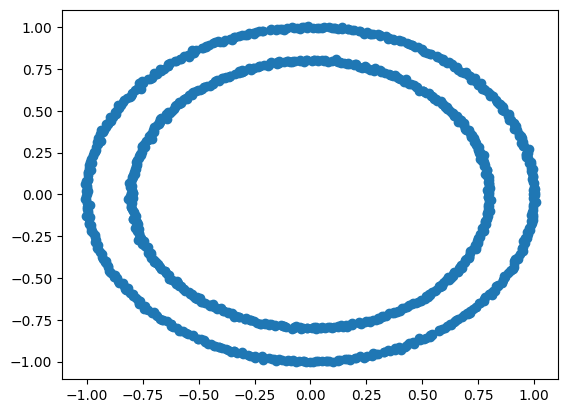

In [2]:
## Get the make circles data ##
data, _ = make_circles(1_000, noise=0.005)

print(f"Shape of the data : {data.shape}, Maximum: {data.max()}, Minimum: {data.min()}")
## Plot for visualization ##
plt.scatter(data[:,0],data[:,1])
plt.show()

In [3]:
## We are going to setup a very simple neural network ##

## Implementing a simple linear layer block with layernorm and GeLU activation ##
class MeanFlowBlock(nn.Module):
  """Implements the LayerNorm --> Linear --> GeLU block."""

  def __init__(self, in_dim, out_dim):
    super().__init__()

    ## Setting the block 33
    self.block = nn.Sequential(
        nn.LayerNorm(in_dim),
        nn.Linear(in_features=in_dim, out_features=out_dim),
        nn.GELU(approximate="tanh"),
    )

  def forward(self, x):
    """Generic forward pass"""
    return self.block(x)

class MeanFlowNet(nn.Module):
  """Implements a mean flow network."""

  def __init__(self,
        in_dim: int = 2,
        out_dim: int = 2,
        hidden_dim: int = 64,
        hidden_block_expansion_sizes: list = [1, 2, 4]
    ):
    """Constructor.

    :args in_dim: The input dimension.
    :args out_dim: The output dimension.
    :args hidden_dim: The hidden layer multiplier size.
    :args hidden_block_expansion_sizes: The hidden blocks multiplier factors.
    """

    super().__init__()

    ## Setting the contraction size which is reverse of the expansion size ##
    hidden_block_contraction_sizes = hidden_block_expansion_sizes[::-1].copy()

    ## We do a first input layer which maps from in_dim+1 --> hidden_dim ##
    ## Hence we add an 1 at index 0 ##
    hidden_block_expansion_sizes.insert(0, 1)

    ## We add the 1 at the end for the contraction sizes ##
    hidden_block_contraction_sizes.append(1)

    ## Our input block which maps from in_dim + 1 --> hidden_dim ##
    ## The + 1 is to include the timestep embedding ##
    self.in_block = nn.Linear(in_dim + 2, hidden_dim)

    ## The expansion blocks where the hidden dim size increases ##
    self.expand_blocks = nn.ModuleList(
        [
          MeanFlowBlock(
              in_dim=hidden_dim * cur_multiplier + 2,
              out_dim=hidden_dim * next_multiplier
          ) for cur_multiplier, next_multiplier in zip(
              hidden_block_expansion_sizes[:-1], hidden_block_expansion_sizes[1:]
            )
        ]
    )

    ## Similarly the contraction blocks are the ones where the sizes decreases ##
    self.contract_blocks = nn.ModuleList(
        [
          MeanFlowBlock(
              in_dim=hidden_dim * cur_multiplier + 2,
              out_dim=hidden_dim * next_multiplier
          ) for cur_multiplier, next_multiplier in zip(
              hidden_block_contraction_sizes[:-1], hidden_block_contraction_sizes[1:]
            )
        ]
    )

    ## Finally the output block ##
    self.out_block = nn.Linear(hidden_dim, out_dim)

  def forward(self, x, t, r):
    """Generic Forward pass.

    :args x : the flow. Shape : (b, d)
    :args t : timestep of the corresponding flow. Shape : (b)
    :args r : second timestep. Shape : (b)
    """

    t = t.view(-1, 1)
    r = r.view(-1, 1)

    ## In block ##
    x = self.in_block(torch.cat((x,t,r), dim=1))

    ## Expand block ##
    for block in self.expand_blocks:
      x = block(torch.cat((x,t,r), dim=1))

    ## Contract block ##
    for block in self.contract_blocks:
      x = block(torch.cat((x,t,r), dim=1))

    ## Final output block ##
    return self.out_block(x)

In [4]:
## Implementing the mean flow module ##

class MeanFlowModule:
  def __init__(self):
    self.model = MeanFlowNet()
    circles, _ = make_circles(1_000, noise=0.005)
    self.data = torch.from_numpy(circles).float()
  def train(self, x):
    bs = len(x)

    ## Sampling timesteps ##
    times = torch.rand(bs,2)
    t = torch.minimum(times[:,0], times[:,1])
    r = torch.maximum(times[:,0], times[:,1])

    t_ = t.view(-1,1)
    r_ = r.view(-1,1)

    ## Getting x_t and the instantaneous velocity ##
    noise = torch.randn(*x.shape, device=x.device, dtype=x.dtype)
    x_t = t_ * x + (1 - t_) * noise
    v_t = x - noise

    ## Getting the model prediction and the jvp + loss ##
    u_pred, dudt = torch.func.jvp(
        lambda x_t, t, r: self.model(x_t, t, r),
        (x_t, t, r),
        (v_t, torch.ones_like(t), torch.zeros_like(r))
    )

    u_target = v_t - (r_ - t_) * dudt
    u_target = u_target.detach()
    loss = (u_pred - u_target) ** 2
    loss = torch.sum(loss, dim=1)
    wt = 1/(loss + 1e-3)
    loss = wt.detach() * loss

    return loss.mean(), ((u_pred - u_target) ** 2).mean().detach()

  def train_loop(self, epochs):
    dl = DataLoader(self.data, batch_size=128, shuffle=True)
    optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
    pbar = tqdm(range(epochs))
    for epoch in pbar:
      for data in dl:
        loss, mse = self.train(data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Epoch -> {epoch}/{epochs}")
        pbar.set_postfix(loss=loss.item(), mse=mse.item())


  @torch.no_grad()
  def sample(self, num_sampling_steps=1):
    x = torch.randn(1, 2)
    step_size = 1/num_sampling_steps
    for i in tqdm(range(num_sampling_steps), leave=True):
      t = torch.tensor([i/num_sampling_steps])
      r = torch.tensor([(i+1)/num_sampling_steps])
      x = x + step_size * self.model(x, t, r)
    return x.detach()


In [5]:
module = MeanFlowModule()

module.train_loop(epochs=500)

Epoch -> 499/500: 100%|██████████| 500/500 [01:35<00:00,  5.25it/s, loss=0.996, mse=1.63]


In [6]:
step_images = {}

for step in [1,2,4,50]:
  step_images[step] = []
  for _ in range(100):
    step_images[step].append(
        module.sample(
            num_sampling_steps=step
        )
    )

100%|██████████| 50/50 [00:00<00:00, 2380.85it/s]


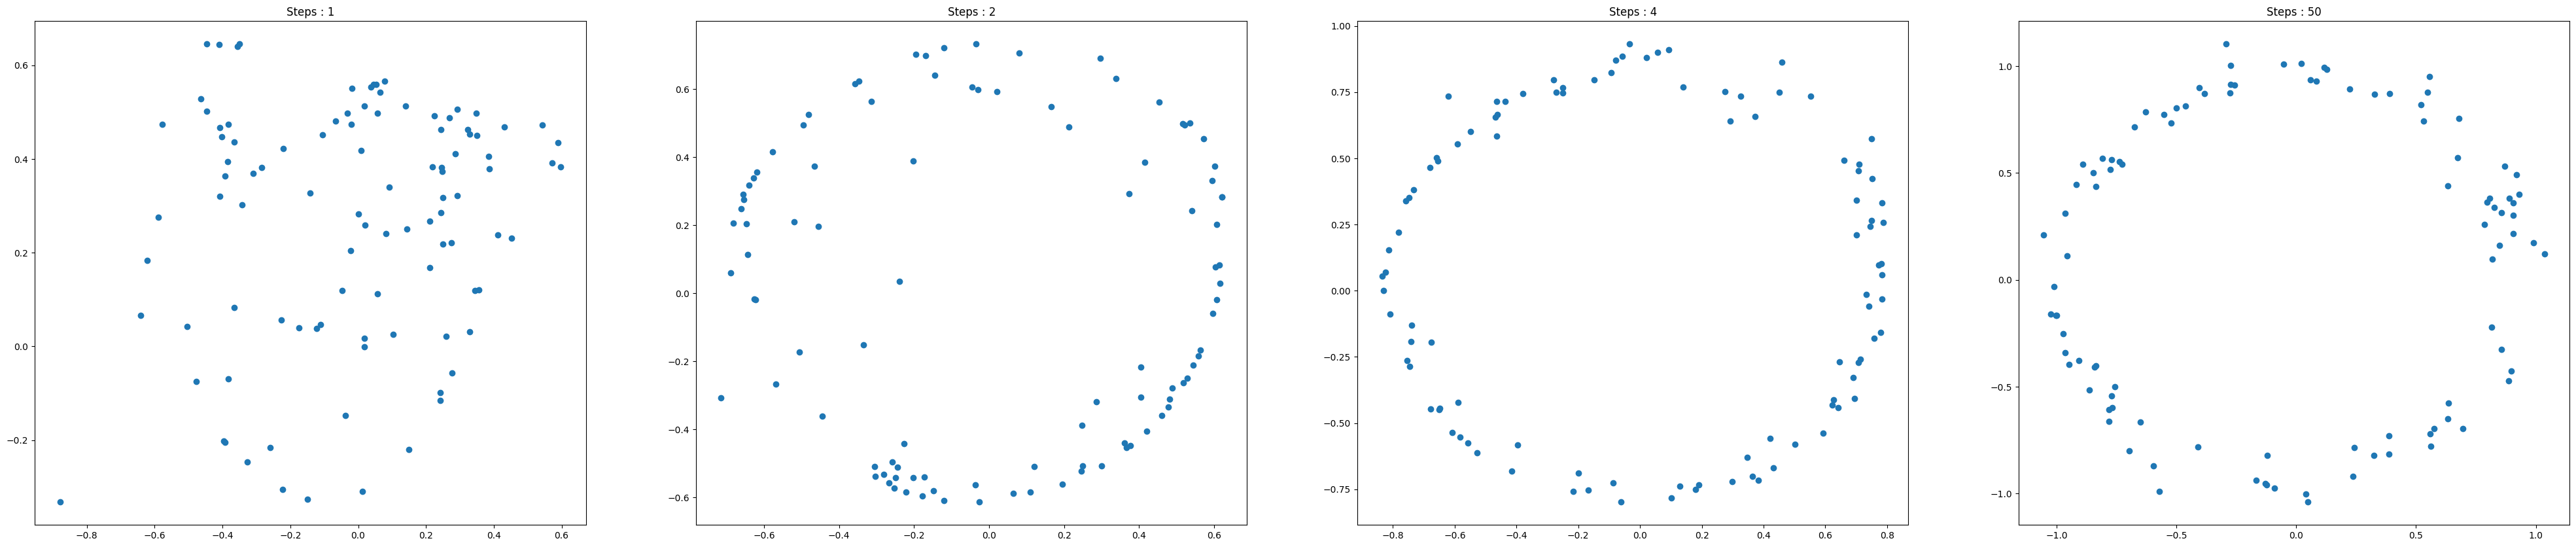

In [7]:
# all_samples = torch.cat(all_samples, dim=0).numpy()
# plt.scatter(all_samples[:,0],all_samples[:,1])
# plt.show()
all_steps = [1,2,4,50]

plt.figure(figsize=(50,10))
for idx, step in enumerate(all_steps):
  all_samples = torch.cat(step_images[step], dim=0).numpy()
  plt.subplot(1, len(all_steps), idx+1)
  plt.scatter(all_samples[:,0],all_samples[:,1])
  plt.title(f"Steps : {step}")